Tuning Random Forest...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Random Forest Parameters: {'class_weight': None, 'max_depth': 20, 'min_samples_leaf': 2, 'n_estimators': 150}
Best Random Forest Accuracy: 0.9654520917678813

Tuning Gradient Boosting...
Fitting 5 folds for each of 81 candidates, totalling 405 fits

Best Gradient Boosting Parameters: {'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 350, 'subsample': 0.7}
Best Gradient Boosting Accuracy: 0.9649122807017544

Tuning XGBoost...
Fitting 5 folds for each of 243 candidates, totalling 1215 fits


d:\kaggel_erto&intro\EnT\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:09:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Best XGBoost Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 350, 'subsample': 0.9}
Best XGBoost Accuracy: 0.964642375168691

Training Voting Classifier (Soft Voting)...
Voting Classifier Accuracy: 0.9651821862348178
              precision    recall  f1-score   support

   Introvert       0.94      0.92      0.93       965
   Extrovert       0.97      0.98      0.98      2740

    accuracy                           0.97      3705
   macro avg       0.96      0.95      0.95      3705
weighted avg       0.97      0.97      0.97      3705


Training Stacking Classifier...
Stacking Classifier Accuracy: 0.9654520917678813
              precision    recall  f1-score   support

   Introvert       0.94      0.92      0.93       965
   Extrovert       0.97      0.98      0.98      2740

    accuracy                           0.97      3705
   macro avg       0.96      0.95      0.95      3705
weighted avg       0.97      0.97      0.97      3705




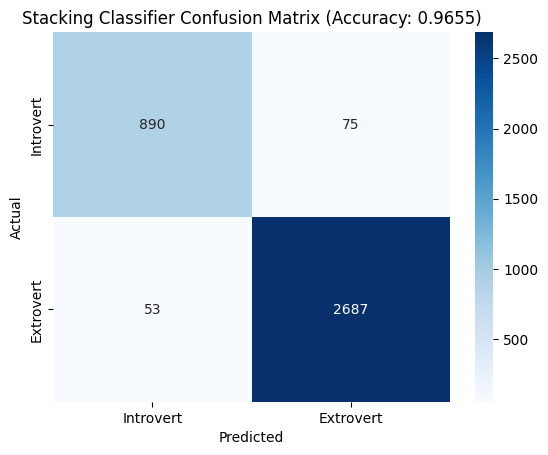


✅ Submission file 'submission.csv' created successfully using the final selected model.


In [ ]:
# score 0.974898
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer # Correct way to enable IterativeImputer
from sklearn.impute import IterativeImputer # Now you can import IterativeImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, QuantileTransformer
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgb

# Load datasets
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# Clean column names
def clean_columns(df):
    df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
    return df

train = clean_columns(train)
test = clean_columns(test)

# --- Advanced Missing Value Handling (Experiment with these) ---
# Option 1: SimpleImputer (as you had)
# num_imputer = SimpleImputer(strategy="mean")
# cat_imputer = SimpleImputer(strategy="most_frequent")

# Option 2: KNNImputer (often better for numerical)
num_imputer = KNNImputer(n_neighbors=5) # You can tune n_neighbors

# Option 3: IterativeImputer (more sophisticated, can be slow for large datasets)
# num_imputer = IterativeImputer(max_iter=10, random_state=42) # Uncomment to use this

# Apply numerical imputation
num_cols = ['time_spent_alone', 'social_event_attendance', 'going_outside',
            'friends_circle_size', 'post_frequency']
train[num_cols] = num_imputer.fit_transform(train[num_cols])
test[num_cols] = num_imputer.transform(test[num_cols])

# Categorical imputation (still 'most_frequent' is often robust here)
cat_cols = ['stage_fear', 'drained_after_socializing']
cat_imputer = SimpleImputer(strategy="most_frequent")
train[cat_cols] = cat_imputer.fit_transform(train[cat_cols])
test[cat_cols] = cat_imputer.transform(test[cat_cols])


# Encode categorical columns
map_dict = {'Yes': 1, 'No': 0}
train['stage_fear'] = train['stage_fear'].map(map_dict)
train['drained_after_socializing'] = train['drained_after_socializing'].map(map_dict)
test['stage_fear'] = test['stage_fear'].map(map_dict)
test['drained_after_socializing'] = test['drained_after_socializing'].map(map_dict)

# Label encode target
target_map = {'Introvert': 0, 'Extrovert': 1}
train['personality'] = train['personality'].map(target_map)

# --- Enhanced Feature Engineering ---
# Your existing features
train['alone_x_post'] = train['time_spent_alone'] * train['post_frequency']
test['alone_x_post'] = test['time_spent_alone'] * test['post_frequency']

train['friends_per_outing'] = train['friends_circle_size'] / (train['going_outside'] + 1)
test['friends_per_outing'] = test['friends_circle_size'] / (test['going_outside'] + 1)

train['activity_index'] = (train['going_outside'] + train['social_event_attendance']) / 2
test['activity_index'] = (test['going_outside'] + test['social_event_attendance']) / 2

train['normalized_alone_time'] = train['time_spent_alone'] / (train['friends_circle_size'] + 1)
test['normalized_alone_time'] = test['time_spent_alone'] / (test['friends_circle_size'] + 1)

train['social_anxiety_score'] = train['stage_fear'] * train['drained_after_socializing']
test['social_anxiety_score'] = test['stage_fear'] * test['drained_after_socializing']

train['log_friends'] = np.log1p(train['friends_circle_size'])
test['log_friends'] = np.log1p(test['friends_circle_size'])

train['log_post_frequency'] = np.log1p(train['post_frequency'])
test['log_post_frequency'] = np.log1p(test['post_frequency'])

# New Feature Engineering Ideas:
train['social_engagement'] = train['social_event_attendance'] + train['going_outside'] + train['friends_circle_size']
test['social_engagement'] = test['social_event_attendance'] + test['going_outside'] + test['friends_circle_size']

train['alone_vs_social'] = train['time_spent_alone'] / (train['social_engagement'] + 1)
test['alone_vs_social'] = test['time_spent_alone'] / (test['social_engagement'] + 1)

train['social_avoidance'] = train['stage_fear'] + train['drained_after_socializing']
test['social_avoidance'] = test['stage_fear'] + test['drained_after_socializing']

# Polynomial features for potentially important numerical features
# from sklearn.preprocessing import PolynomialFeatures
# poly = PolynomialFeatures(degree=2, include_bias=False)
# # Select features for polynomial expansion. Be careful, this can explode feature space.
# poly_features = ['time_spent_alone', 'friends_circle_size']
# train_poly = poly.fit_transform(train[poly_features])
# test_poly = poly.transform(test[poly_features])
# train = pd.concat([train.drop(columns=poly_features), pd.DataFrame(train_poly, columns=poly.get_feature_names_out(poly_features), index=train.index)], axis=1) # Added index=train.index
# test = pd.concat([test.drop(columns=poly_features), pd.DataFrame(test_poly, columns=poly.get_feature_names_out(poly_features), index=test.index)], axis=1) # Added index=test.index


# Define features - ensure all new features are included
features = [
    'time_spent_alone', 'social_event_attendance', 'going_outside',
    'friends_circle_size', 'post_frequency', 'stage_fear', 'drained_after_socializing',
    'alone_x_post', 'friends_per_outing', 'activity_index', 'normalized_alone_time',
    'social_anxiety_score', 'log_friends', 'log_post_frequency',
    'social_engagement', 'alone_vs_social', 'social_avoidance'
]
# If you used PolynomialFeatures, you'd update this to include the new column names

X = train[features]
y = train['personality']
X_test = test[features]

# --- Scaling Numerical Features ---
# It's good practice for many models, especially SVMs, Logistic Regression, and Neural Networks.
# Tree-based models are less sensitive but it doesn't hurt.
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_test = scaler.transform(X_test)

# Convert back to DataFrame for consistency with previous steps if needed for feature names in GridSearchCV
X = pd.DataFrame(X, columns=features)
X_test = pd.DataFrame(X_test, columns=features)


# Split data for validation
# Using StratifiedKFold for robust cross-validation within GridSearchCV
# and for evaluating final models more robustly if you skip train_test_split for final training
X_train_val, X_val, y_train_val, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Define KFold for GridSearchCV and Stacking
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ------------------------
# Hyperparameter Tuning for Random Forest
# ------------------------
print("Tuning Random Forest...")
param_grid_rf = {
    'n_estimators': [150, 250, 350], # Increased range
    'max_depth': [10, 20, None], # Adjusted depth
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced', None]
}

grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=kf, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search_rf.fit(X_train_val, y_train_val)

best_rf = grid_search_rf.best_estimator_
best_rf_pred = best_rf.predict(X_val)

print("Best Random Forest Parameters:", grid_search_rf.best_params_)
print("Best Random Forest Accuracy:", accuracy_score(y_val, best_rf_pred))

# ------------------------
# Hyperparameter Tuning for Gradient Boosting Classifier
# ------------------------
print("\nTuning Gradient Boosting...")
param_grid_gb = {
    'n_estimators': [150, 250, 350], # Increased range
    'learning_rate': [0.03, 0.07, 0.1], # Finer tuning
    'max_depth': [3, 4, 5],
    'subsample': [0.7, 0.8, 0.9] # Explore subsampling
}

grid_search_gb = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid_gb, cv=kf, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search_gb.fit(X_train_val, y_train_val)

best_gb = grid_search_gb.best_estimator_
best_gb_pred = best_gb.predict(X_val)

print("\nBest Gradient Boosting Parameters:", grid_search_gb.best_params_)
print("Best Gradient Boosting Accuracy:", accuracy_score(y_val, best_gb_pred))

# ------------------------
# Hyperparameter Tuning for XGBoost
# ------------------------
print("\nTuning XGBoost...")
param_grid_xgb = {
    'n_estimators': [150, 250, 350],
    'learning_rate': [0.03, 0.07, 0.1],
    'max_depth': [3, 4, 5],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9] # Column subsampling
}

grid_search_xgb = GridSearchCV(xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=42),
                             param_grid_xgb, cv=kf, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search_xgb.fit(X_train_val, y_train_val)

best_xgb = grid_search_xgb.best_estimator_
best_xgb_pred = best_xgb.predict(X_val)

print("\nBest XGBoost Parameters:", grid_search_xgb.best_params_)
print("Best XGBoost Accuracy:", accuracy_score(y_val, best_xgb_pred))

# ------------------------
# Ensemble with VotingClassifier (Soft Voting)
# ------------------------
print("\nTraining Voting Classifier (Soft Voting)...")
# Ensure base estimators are your best-tuned models
estimators = [
    ('rf', best_rf),
    ('gb', best_gb),
    ('xgb', best_xgb)
]

# Weight by validation accuracy for better performance
rf_val_acc = accuracy_score(y_val, best_rf_pred)
gb_val_acc = accuracy_score(y_val, best_gb_pred)
xgb_val_acc = accuracy_score(y_val, best_xgb_pred)

# Normalize weights so they sum to 1
total_acc = rf_val_acc + gb_val_acc + xgb_val_acc
weights = [rf_val_acc / total_acc, gb_val_acc / total_acc, xgb_val_acc / total_acc]


voting_clf = VotingClassifier(
    estimators=estimators,
    voting='soft', # Use soft voting for probabilities
    weights=weights,
    n_jobs=-1
)
voting_clf.fit(X_train_val, y_train_val)
voting_pred = voting_clf.predict(X_val)
print("Voting Classifier Accuracy:", accuracy_score(y_val, voting_pred))
print(classification_report(y_val, voting_pred, target_names=['Introvert', 'Extrovert']))


# ------------------------
# Ensemble with StackingClassifier (More Advanced Ensemble)
# ------------------------
print("\nTraining Stacking Classifier...")
# Base models for stacking
level0_estimators = [
    ('rf', best_rf),
    ('gb', best_gb),
    ('xgb', best_xgb),
    ('lr', LogisticRegression(solver='liblinear', random_state=42)) # Add a diverse simple model
]

# Meta-learner (final model that combines base predictions)
level1_estimator = LogisticRegression(solver='liblinear', random_state=42) # Can also be a small neural network or another tree model

stacking_clf = StackingClassifier(
    estimators=level0_estimators,
    final_estimator=level1_estimator,
    cv=kf, # Use cross-validation to train the meta-learner
    n_jobs=-1,
    passthrough=True # Pass original features to meta-learner as well
)

stacking_clf.fit(X_train_val, y_train_val)
stacking_pred = stacking_clf.predict(X_val)
print("Stacking Classifier Accuracy:", accuracy_score(y_val, stacking_pred))
print(classification_report(y_val, stacking_pred, target_names=['Introvert', 'Extrovert']))


# ------------------------
# Final Model Selection for Submission
# Compare validation accuracies of Voting and Stacking and choose the best one.
if accuracy_score(y_val, voting_pred) >= accuracy_score(y_val, stacking_pred):
    final_model_for_submission = voting_clf
    final_model_name = "Voting Classifier"
    final_val_accuracy = accuracy_score(y_val, voting_pred)
else:
    final_model_for_submission = stacking_clf
    final_model_name = "Stacking Classifier"
    final_val_accuracy = accuracy_score(y_val, stacking_pred)

print(f"\nSelected final model for submission: {final_model_name} with validation accuracy: {final_val_accuracy:.4f}")

# ------------------------
# Confusion Matrix for the Final Selected Model
# ------------------------
final_predictions_val = final_model_for_submission.predict(X_val)
cm_final_model = confusion_matrix(y_val, final_predictions_val)
sns.heatmap(cm_final_model, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Introvert', 'Extrovert'], yticklabels=['Introvert', 'Extrovert'])
plt.title(f"{final_model_name} Confusion Matrix (Accuracy: {final_val_accuracy:.4f})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ------------------------
# Generate Submission
# ------------------------
test_pred_final = final_model_for_submission.predict(X_test)
test_pred_final = pd.Series(test_pred_final).map({0: 'Introvert', 1: 'Extrovert'})

submission = pd.DataFrame({
    'id': test['id'],
    'personality': test_pred_final
})
submission.to_csv("submission.csv", index=False)
print("\n✅ Submission file 'submission.csv' created successfully using the final selected model.")